# Re-writing DLT to follow R. Hyndman's 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from orbit.dlt_rh import DLTRH
from orbit.eswr import ESWR
from orbit.dlt import DLT
import numpy as np
from orbit.models import get_compiled_stan_model
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components
from orbit.backtest.backtest import TimeSeriesSplitter, Backtest
from orbit.backtest.functions import run_multi_series_backtest

In [2]:
DATA_FILE = "./data/iclaims_example.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [4]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
raw_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


### Train / Test Split

In [6]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [7]:
response_col = 'claims'

In [8]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


In [9]:
mod = DLTRH(
    is_multiplicative=True, seed=2020,
    response_col='claims', date_col='week', seasonality=52, 
    normalize_seasonality=1,
    infer_method='map', predict_method='map')

In [25]:
mod.fit(train_df)

In [26]:
fit = mod.aggregated_posteriors['map']

In [27]:
fit.keys()

dict_keys(['l', 'b', 'l_sm', 'b_sm', 'obs_sigma', 'nu', 'gb', 'gt_sum', 's', 's_sm'])

In [114]:
# s = fit['s']
# l = fit['l']
# gb = fit['gb']
# l_ext = np.expand_dims(np.tile(l[:, -1], 51), 0)
# l = np.concatenate([l, l_ext], axis=1)

In [115]:
# b = fit['b']
# b_ext = [b[:, -1] * mod.damped_factor]
# for i in range(2,52):
#     b_ext.append(b_ext[-1] * mod.damped_factor)
# b_ext = np.array(b_ext).reshape(1, -1)
# b = np.concatenate([b, b_ext], axis=1)

In [116]:
# gt = gb * np.arange(0, l.shape[1])
# gt = gt.reshape(1, -1)

In [117]:
# print(l.shape, s.shape, b.shape, l_ext.shape, b_ext.shape, gt.shape)

In [118]:
s = fit['s']
l = fit['l']
gb = fit['gb']
l_ext = np.expand_dims(np.tile(l[:, -1], 52), 0)
l = np.concatenate([l, l_ext], axis=1)

In [129]:
s[:, 2:54].sum()

0.008334056045126381

In [88]:
b = fit['b']
b_ext = [b[:, -1] * mod.damped_factor]
for i in range(1,52):
    b_ext.append(b_ext[-1] * mod.damped_factor)
b_ext = np.array(b_ext).reshape(1, -1)
b = np.concatenate([b, b_ext], axis=1)

In [89]:
gt = gb * np.arange(0, l.shape[1])
gt = gt.reshape(1, -1)

In [90]:
print(l.shape, s.shape, b.shape, l_ext.shape, b_ext.shape, gt.shape)

(1, 443) (1, 443) (1, 443) (1, 52) (1, 52) (1, 443)


In [91]:
yhat= gt + l + s + b
yhat =np.squeeze(yhat)

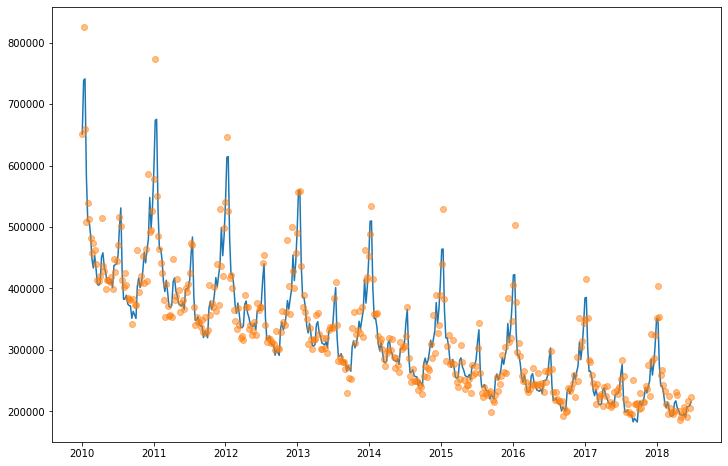

In [92]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
y = df[response_col]
plt.plot(df['week'], np.exp(yhat))
plt.plot(df['week'], df[response_col], 'o', alpha=0.5)

In [93]:
predicted_df = mod.predict(df)

In [94]:
predicted_df.tail(52)

,week,prediction
391,2017-07-02,259994.375635
392,2017-07-09,276488.970192
393,2017-07-16,221472.158792
394,2017-07-23,198980.341644
395,2017-07-30,199516.101781
396,2017-08-06,202478.512477
397,2017-08-13,195210.266772
398,2017-08-20,193736.856432
399,2017-08-27,193564.532319
400,2017-09-03,182983.767358


In [95]:
np.exp(yhat[-52:])

array([259994.18728914, 276488.60966091, 221471.76732018, 198979.9161259 ,
       199515.61591593, 202477.9713338 , 195209.70798333, 193736.2724275 ,
       193563.92530879, 182983.17573655, 188827.04091572, 185896.91105326,
       182762.58140365, 210137.29279007, 216813.0284998 , 208931.12553233,
       213506.70615685, 223357.84117062, 238792.15801742, 229856.39461773,
       240825.82492172, 250043.58958707, 285263.0625196 , 259109.57015021,
       277689.73308499, 308823.31147867, 350510.96240829, 351444.8120778 ,
       275969.25774332, 241630.62005849, 241946.06192215, 231634.07768016,
       212978.18153321, 205576.71528896, 215233.77031575, 204946.84359329,
       192983.34299581, 192196.73063261, 193863.74076808, 213921.35316161,
       217231.54564023, 206060.03309932, 202006.84736471, 195286.1608117 ,
       194378.32206195, 193253.74265189, 196593.65819889, 190345.24592783,
       207353.46079695, 208076.63737087, 208899.12803863, 215357.00850345])

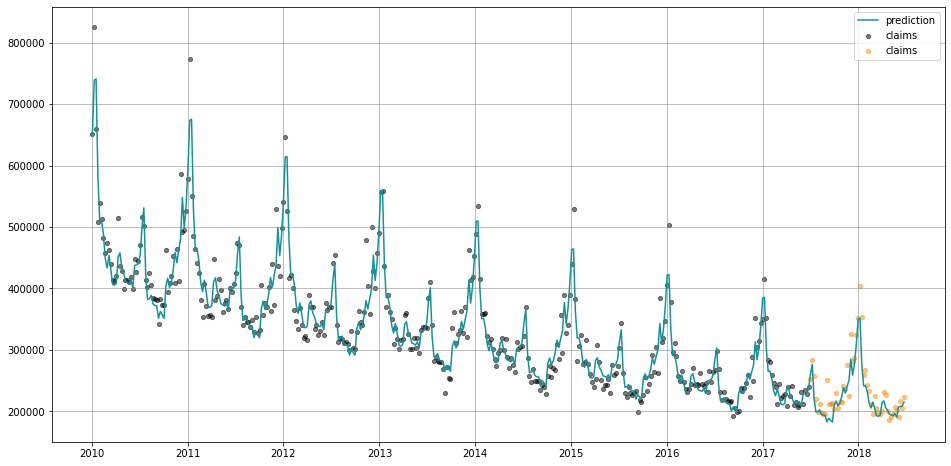

In [96]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=mod.date_col, actual_col=mod.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [97]:
# backtest on more data

# data = pd.read_csv('./data/uber_uscan_rider_uFT.csv', parse_dates=['event_week'])
# data = pd.read_csv('./data/uber_uscan_driver_uFT.csv', parse_dates=['event_week'])
# response_col = 'uFT'
# date_col='event_week'
# key_col = 'city_name'
# predicted_col='prediction'
# min_train_len = 380
# forecast_len = 26
# incremental_len = 13
# n_splits=2
# key_col = "city_name"
# window_type = 'expanding'
# seasonality=52

data = pd.read_csv('./data/m3_monthly.csv', parse_dates=['date'])
response_col = 'value'
date_col='date'
key_col = 'key'
predicted_col='prediction'
min_train_len = 380
forecast_len = 18
incremental_len = 18
n_splits=1
window_type = 'expanding'
seasonality=12

# data = pd.read_csv('./data/m4_weekly.csv', parse_dates=['date'])
# response_col = 'value'
# date_col='date'
# key_col = 'key'
# predicted_col='prediction'
# min_train_len = 380
# forecast_len = 13
# incremental_len = 13
# n_splits=1
# window_type = 'expanding'
# seasonality=52

In [98]:
seed=2020

In [99]:
data.dtypes

key              object
value           float64
date     datetime64[ns]
dtype: object

In [100]:
uni_keys = data[key_col].unique()

Instantiate a model that we want to backtest

In [106]:
mod = DLTRH(
    is_multiplicative=True, seed=seed,
    response_col=response_col, date_col=date_col, seasonality=seasonality, 
    normalize_seasonality=1,
    infer_method='map', predict_method='map')

In [107]:
%%time
bt_result, bt_scores = run_multi_series_backtest(
    data=data, 
    response_col=response_col, 
    key_col=key_col, 
    date_col=date_col,
    model=mod,
    min_train_len=min_train_len, 
    incremental_len=incremental_len, 
    forecast_len=forecast_len, 
    predicted_col=predicted_col, 
    n_splits=n_splits,
    window_type = window_type
)

100%|██████████| 1399/1399 [02:46<00:00,  8.41it/s]


CPU times: user 2min 32s, sys: 4.98 s, total: 2min 37s
Wall time: 2min 47s


In [108]:
bt_scores['smape'].mean()

0.15820130184405004

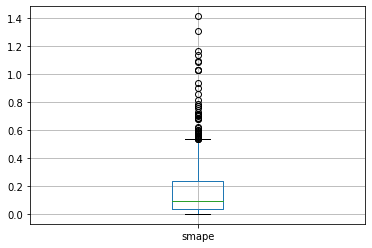

In [109]:
bt_scores.boxplot(column='smape')

In [45]:
mod2 = DLT(
    is_multiplicative=True, seed=seed,
    response_col=response_col, date_col=date_col, seasonality=seasonality, 
    infer_method='map', predict_method='map')

In [46]:
%%time
bt_result2, bt_scores2 = run_multi_series_backtest(
    data=data, 
    response_col=response_col, 
    key_col=key_col, 
    date_col=date_col,
    model=mod2,
    min_train_len=min_train_len, 
    incremental_len=incremental_len, 
    forecast_len=forecast_len, 
    predicted_col=predicted_col, 
    n_splits=n_splits,
    window_type = window_type
)

100%|██████████| 1399/1399 [02:02<00:00, 11.39it/s]


CPU times: user 1min 53s, sys: 5.8 s, total: 1min 59s
Wall time: 2min 4s


In [47]:
bt_scores2['smape'].mean()

0.14827365152127073

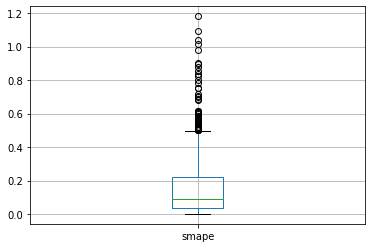

In [48]:
bt_scores2.boxplot(column='smape')

In [ ]:
# TODO:
# compare 
# 1. using normalize vs. not use -- non-normalized is better 
# 2. subtract init lev by s[1] vs. by s[SEASONALITY] -- after some thought, s[SEASONALITY]
# should be the right one
# 3. changing different ways to get init_lev prior -- using l[1] seems even worse
# 4. random initialize seasonality vs. random normal initialization -- not too much difference
# 5. changing NUs of student t to see if letting stan to optimize makes better accuracy <--- This is TODO!
# tried 10 vs. 5 doesn't matter (when normalizing)

# NOTES:
# it doesn't do as well as the original DLT but meanwhile does not do worse (improvment on rider but relatively similar in driver and slightly worse in M3 Monthly)